In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn
from tied_utils import simulated_tied_ddm_norm, tied_data_gen_wrapper, rho_E_minus_small_t_NORM_TIED_fn

In [3]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

In [4]:
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

In [5]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [6]:
# LED off rows
df_1 = df[ df['LED_trial'] == 0 ]
df_1 = df_1[ df_1['timed_fix'] > df_1['intended_fix'] ]

# VBMC

## loglike

In [44]:
def compute_loglike(res, rate_lambda, theta_E, T_0, t_non_decision):
    ILD = res['ILD']
    ABL = res['ABL']
    # choice = res['choice']
    choice = res['response_poke']
    # rt = res['rt']
    rt = res['timed_fix'] - res['intended_fix']
    K_max = 10
    if choice == 3:
        prob = rho_E_minus_small_t_NORM_TIED_fn(rt, ILD, ABL, rate_lambda, -theta_E, T_0, t_non_decision, K_max)
    elif choice == 2:
        prob = rho_E_minus_small_t_NORM_TIED_fn(rt, ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, K_max)

    if prob <= 0:
        prob = 1e-50
    
    log_prob = np.log(prob)

    return log_prob

def tied_loglike_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision = params

    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(res, rate_lambda, theta_E, T_0, t_non_decision) 
                                      for _, res in df_1.iterrows() if res['response_poke'] in [2,3])
    loglike = np.sum(all_loglike)

    return loglike

## bounds

In [45]:
rate_lambda_bounds = [0.01, 0.3]
theta_E_bounds = [10, 90]
T_0_bounds = [0.1*(1e-3), 2*(1e-3)]
t_non_decision_bounds = [10*(1e-3), 100*(1e-3)]

rate_lambda_plausible_bounds = [0.05, 0.1]
theta_E_plausible_bounds = [40, 55]
T_0_plausible_bounds = [0.15*(1e-3), 0.8*(1e-3)]
t_non_decision_plausible_bounds = [65*(1e-3), 85*(1e-3)]

## priors

In [46]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def tied_prior_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], \
                                            rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], \
                                            theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], \
                                            T_0_plausible_bounds[1], T_0_bounds[1])
    t_non_decision_logpdf = trapezoidal_logpdf(t_non_decision, t_non_decision_bounds[0], t_non_decision_plausible_bounds[0], \
                                            t_non_decision_plausible_bounds[1], t_non_decision_bounds[1])
    
    return rate_lambda_logpdf + theta_E_logpdf + T_0_logpdf + t_non_decision_logpdf

## joint

In [47]:
def tied_joint_fn(params):
    return tied_loglike_fn(params) + tied_prior_fn(params)

## run vbmc

In [48]:
lb = np.array([rate_lambda_bounds[0], theta_E_bounds[0], T_0_bounds[0], t_non_decision_bounds[0]])
ub = np.array([rate_lambda_bounds[1], theta_E_bounds[1], T_0_bounds[1], t_non_decision_bounds[1]])
plb = np.array([rate_lambda_plausible_bounds[0], theta_E_plausible_bounds[0], T_0_plausible_bounds[0], t_non_decision_plausible_bounds[0]])
pub = np.array([rate_lambda_plausible_bounds[1], theta_E_plausible_bounds[1], T_0_plausible_bounds[1], t_non_decision_plausible_bounds[1]])

np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
t_non_decision_0 = np.random.uniform(t_non_decision_plausible_bounds[0], t_non_decision_plausible_bounds[1])

x0 = np.array([rate_lambda_0, theta_E_0, T_0_0, t_non_decision_0])

vbmc = VBMC(tied_joint_fn, x0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: 5287.490 +/-20.120.
Caution: Returned variational solution may have not converged.


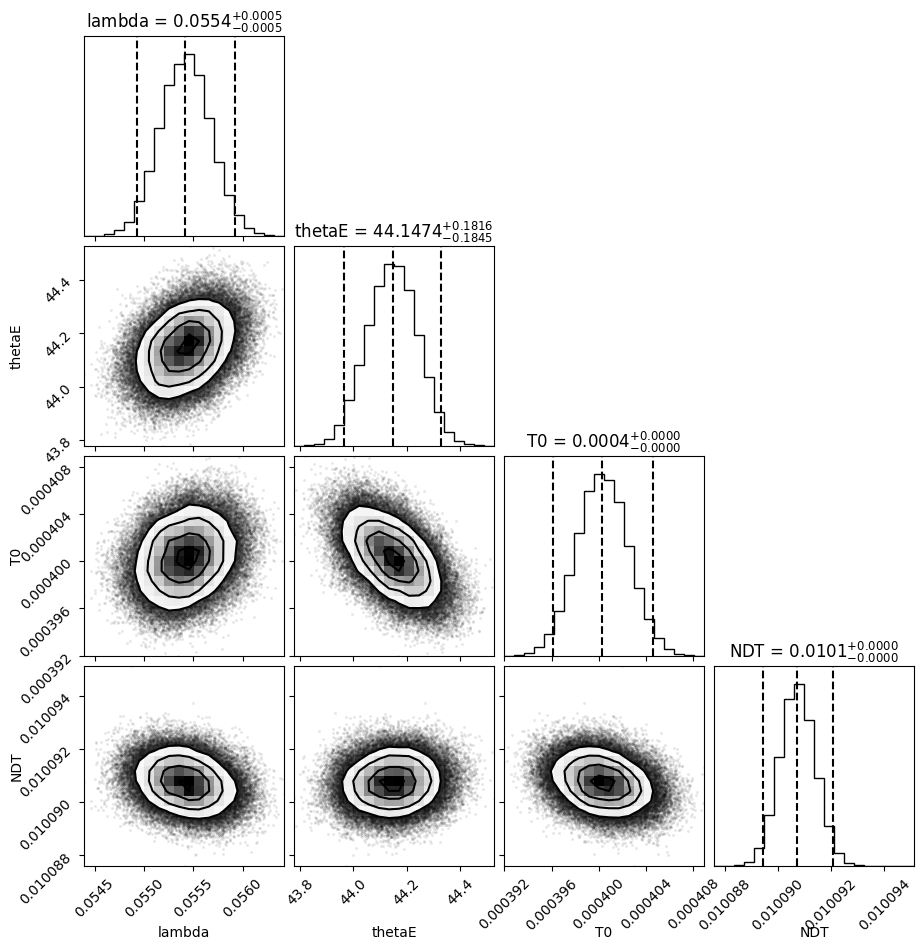

In [49]:
vp_samples = vp.sample(int(1e5))[0]

rate_lambda_samp = vp_samples[:, 0]
theta_E_samp = vp_samples[:, 1]
T_0_samp = vp_samples[:, 2]
t_non_decision_samp = vp_samples[:, 3]

combined_samples = np.transpose(np.vstack((rate_lambda_samp, theta_E_samp, T_0_samp, t_non_decision_samp)))
param_labels = ['lambda', 'thetaE', 'T0', 'NDT']

corner.corner(combined_samples, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975], title_fmt=".4f"  );

(0.0, 1.0)

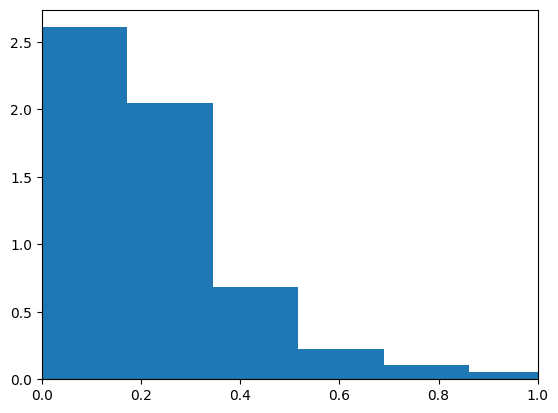

In [39]:
plt.hist(df_1['timed_fix'] - df_1['intended_fix'], bins=50, density=True);
plt.xlim(0,1)